# **VGG 19**

**Importing librares**

In [1]:

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

tf.__version__

'2.6.0'

# **Data Generator**

**Mounting drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**slpiting in train,test and validation**

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/Resized_Original_Data", output="/content/drive/MyDrive/splited_train_test_rice_data", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


**Data augmentation**

In [4]:
# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/splited_train_test_rice_data/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/splited_train_test_rice_data/test',
                                            target_size = (224, 224)
                                            )


Found 1120 images belonging to 9 classes.
Found 149 images belonging to 9 classes.


In [5]:
training_set.image_data_generator

**Building our model without top layer**

In [6]:
# from tensorflow.keras.applications.vgg19 import VGG19
# #vgg = VGG19(weights="../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5",include_top = False,input_shape=(224,244,3))
# vgg = VGG19(weights="../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5",
#             include_top = False,input_shape=(224,224,3)
#            )
# for layer in vgg.layers:
#     layer.trainable = False
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Flatten,Dense
# model = Sequential()
# model.add(vgg)
# model.add(Flatten())
# model.add(Dense(2,activation="sigmoid"))
# model.summary()


# Part 2 - Building the CNN
from tensorflow.keras.applications.vgg19 import VGG19
input_tensor = Input(shape=(224, 224, 3))
vgg_weights = "/content/drive/MyDrive/vgg19_weight/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = tf.keras.applications.VGG19(
    input_tensor=input_tensor,
    include_top  = False,
    weights      = None,
)
base_model.load_weights(vgg_weights)
x = base_model.output
print(base_model.input)
print(base_model.output)




KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


# ===============After traing===========

# ===============After traing===========

In [7]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
#base_model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()
#x = Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(9,activation="softmax")

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential([base_model,
                   x,
                    predictions
                ])
print(model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 4617      
Total params: 20,029,001
Trainable params: 20,029,001
Non-trainable params: 0
_________________________________________________________________


In [9]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
#base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

In [11]:
def get_callbacks(name):
    return[
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy',patience=1),
    ]

In [12]:
base_learning_rate  = 0
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy",metrics=[tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),'accuracy'])


In [13]:
base_learning_rate  = 0
base_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy",metrics=[tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),'accuracy'])


**Defining checkpoint(checkpoint directory,saving frequency)**

In [14]:
import os
checkpoint_path='drive/MyDrive/saved_point/cp-{epoch:04d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,verbose=1,save_weights_only=True,save_freq=500)

In [ ]:
history = model.fit(x = training_set,epochs= 1000, validation_data = test_set,callbacks=[cp_callback])

# **Load last checkpoint and evaluate test accuracy**

In [ ]:
latest=tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [ ]:
history = model.fit(x = training_set,epochs= 1000, validation_data = test_set)

# **Evaluating the model**

In [ ]:
model.load_weights('/content/drive/MyDrive/model_trained.h5')
model.evaluate(test_set)

In [ ]:
model.

# **Visualization**

TypeError: ignored

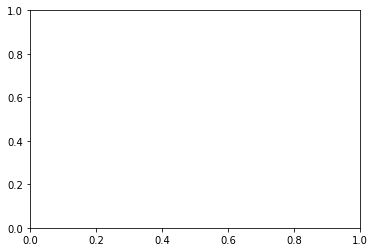

In [19]:
import matplotlib.pyplot as plt
# Accuracy/validation plots
h = model.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid(False)
plt.title(f'Training and validation accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid(False)
plt.title(f'Training and Test loss')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive')

In [ ]:
model.save_weights("/content/drive/MyDrive/model_trained.h5")

In [ ]:
tf.keras.models.save_model(
    model,
    "/content/drive/MyDrive/keras_saved_1",
    overwrite=True,
    include_optimizer=True,
    save_format='h5',
    signatures=None,
    options=None,
    save_traces=True,
)